# 基本信息

In [1]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score,precision_recall_curve,roc_curve
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,KFold,GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures,OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras
import graphviz
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import random
from bayes_opt import BayesianOptimization
sns.set(style="white", color_codes=True)
#显示所有列
pd.set_option('display.max_columns', None)
#取消科学计数，显示小数点后1位
pd.set_option('float_format', lambda x: '%.1f' % x)
# pd.set_option('display.max_rows', None)
seed = 100
np.random.seed(seed)
random.seed(seed)

In [2]:
trainfile = 'train.csv'
train_data = pd.read_csv(trainfile)
print("rows:",train_data.shape[0]," columns:", train_data.shape[1])

rows: 1521787  columns: 23


In [3]:
testfile = 'test.csv'
test_data = pd.read_csv(testfile)
print("rows:",test_data.shape[0]," columns:", test_data.shape[1])

rows: 421665  columns: 22


In [4]:
# 改时间为小时
def change_time(data):
    time = data['loctm']
    newtime = []
    for i in time:
        k = int(i/10000)
        newtime.append(k)
    data['loctm'] = newtime

In [5]:
change_time(train_data)
change_time(test_data)

In [6]:
train_data = train_data.replace(['N','Y'],[0,1])
test_data = test_data.replace(['N','Y'],[0,1])

In [7]:
# features interaction 并使用 labelencoder
cb_feature = ['bacno__cano','stocn__csmcu','stocn__acqic','scity__acqic','mcc__stocn',
              'mcc__scity','mcc__ecfg','mcc__mchno','csmcu__acqic','ecfg__stscd',
              'etymd__csmcu',
              'stocn__scity','stocn__ecfg','mcc__etymd','mcc__csmcu','mcc__acqic','scity__ecfg']

for feature in cb_feature:
    f1,f2 = feature.split('__')
    train_data[feature] = train_data[f1].astype(str) + '_' + train_data[f2].astype(str)
    test_data[feature] = test_data[f1].astype(str) + '_' + test_data[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train_data[feature].astype(str).values) + list(test_data[feature].astype(str).values))
    train_data[feature] = le.transform(list(train_data[feature].astype(str).values))
    test_data[feature] = le.transform(list(test_data[feature].astype(str).values))
print(train_data.columns)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'bacno__cano', 'stocn__csmcu', 'stocn__acqic', 'scity__acqic',
       'mcc__stocn', 'mcc__scity', 'mcc__ecfg', 'mcc__mchno', 'csmcu__acqic',
       'ecfg__stscd', 'etymd__csmcu', 'stocn__scity', 'stocn__ecfg',
       'mcc__etymd', 'mcc__csmcu', 'mcc__acqic', 'scity__ecfg'],
      dtype='object')


In [8]:
# Count Encoding 
cn_feature = ['acqic','bacno','cano','scity','mcc','mchno','conam','csmcu','bacno__cano','stocn__csmcu','stocn__acqic',
'scity__acqic','mcc__stocn','mcc__scity','mcc__mchno','csmcu__acqic','ecfg__stscd','stocn__scity',
              'stocn__ecfg','scity__ecfg','mcc__etymd','mcc__csmcu','mcc__acqic']
for feature in cn_feature :
    train_data[feature + '_count_full'] = train_data[feature].map(pd.concat([train_data[feature], test_data[feature]], ignore_index=True).value_counts(dropna=False))
    test_data[feature + '_count_full'] = test_data[feature].map(pd.concat([train_data[feature], test_data[feature]], ignore_index=True).value_counts(dropna=False))   
print(train_data.columns)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'bacno__cano', 'stocn__csmcu', 'stocn__acqic', 'scity__acqic',
       'mcc__stocn', 'mcc__scity', 'mcc__ecfg', 'mcc__mchno', 'csmcu__acqic',
       'ecfg__stscd', 'etymd__csmcu', 'stocn__scity', 'stocn__ecfg',
       'mcc__etymd', 'mcc__csmcu', 'mcc__acqic', 'scity__ecfg',
       'acqic_count_full', 'bacno_count_full', 'cano_count_full',
       'scity_count_full', 'mcc_count_full', 'mchno_count_full',
       'conam_count_full', 'csmcu_count_full', 'bacno__cano_count_full',
       'stocn__csmcu_count_full', 'stocn__acqic_count_full',
       'scity__acqic_count_full', 'mcc__stocn_count_full',
       'mcc__scity_count_full', 'mcc__mchno_count_full',
       'csmcu__acqic_count_full', 'ecfg__stscd_count_full',
       'stocn__scity_count_full', 'stocn__ecfg

In [9]:
# Group by  \ train_test 需合并？
train_test = train_data.append(test_data)
for uid in ['bacno__cano']:
    for feature in ['acqic','csmcu','conam','loctm','ecfg','etymd','mcc','mchno','stocn','scity','stscd']:
        col_mean = train_test.groupby(uid)[feature].mean()
        train_data[feature + '_to_mean_' + uid] = train_data[uid].map(col_mean)
        test_data[feature + '_to_mean_' + uid] = test_data[uid].map(col_mean)
              
        col_std = train_test.groupby(uid)[feature].std(ddof = 0)
        train_data[feature + '_to_std_' + uid] = train_data[uid].map(col_std)
        test_data[feature + '_to_std_' + uid] = test_data[uid].map(col_std)
    
#     train_data['conam_devide_mean_' + feature] = train_data['conam']/ train_data.groupby([feature])['conam'].transform('mean')
#     test_data['conam_devide_mean_' + feature] = test_data['conam'] / test_data.groupby([feature])['conam'].transform('mean')

C:\Users\kiwi\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [10]:
model1_features = list(train_data.columns)
del_col = ['txkey','locdt','insfg','iterm','flg_3dsmk','flbmk','contp','hcefg','ovrlt','fraud_ind',
           'stocn__scity','stocn__ecfg','scity__ecfg','mcc__etymd','mcc__csmcu','mcc__acqic']
for col in del_col:
    model1_features.remove(col)
    
X_train = train_data[model1_features]
Y_train = train_data['fraud_ind']
X_test = test_data[model1_features]
print(X_train.shape,X_test.shape)
print(X_train.info())

(1521787, 69) (421665, 69)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521787 entries, 0 to 1521786
Data columns (total 69 columns):
acqic                        1521787 non-null int64
bacno                        1521787 non-null int64
cano                         1521787 non-null int64
conam                        1521787 non-null float64
csmcu                        1521787 non-null int64
ecfg                         1521787 non-null int64
etymd                        1521787 non-null int64
loctm                        1521787 non-null int64
mcc                          1521787 non-null int64
mchno                        1521787 non-null int64
scity                        1521787 non-null int64
stocn                        1521787 non-null int64
stscd                        1521787 non-null int64
bacno__cano                  1521787 non-null int64
stocn__csmcu                 1521787 non-null int64
stocn__acqic                 1521787 non-null int64
scity__acqic              

In [11]:
def show_cor(df1):
    plt.figure(figsize = (20,20))
    df_corr = df1.corr()
    sns.heatmap(df_corr,fmt = '0.2f',annot = True,xticklabels=df_corr.columns,yticklabels=df_corr.columns,cmap="Reds")
    plt.show()

In [ ]:
show_cor(X_train)

In [12]:
    params = {'max_depth': 48,
              'gamma': 0.15626466439591735,
              'n_estimators': 5000,
              'learning_rate':0.009731568389839462,
              'min_child_weight':1.5233399970515784, 
              'colsample_bytree':0.866451818270932,
              'subsample':0.8997425055522636,
              'reg_alpha':4.989195734088519,
              'reg_lambda':4.292050649851185,
              'scale_pos_weight':73.76231884057971,
              'eta': 0.1,
              'missing' : -1,
              'objective' :'binary:logistic',
              'tree_method':'gpu_hist',
              'eval_metric': 'auc'}

In [13]:
    predictions = np.zeros(len(X_test))
    splits = 3
    folds = GroupKFold(n_splits = splits)
    split_groups = train_data['locdt']
#auc = {}
#test_feature = cb_feature + cf_feature
#print(len(test_feature))
#for col in test_feature:
    feature = model1_features.copy()
    #feature.append(col)
    #print(feature)
    X_train = train_data[feature].copy()
    Y_train = train_data['fraud_ind'].copy()
    oof = np.zeros(len(X_train))
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values,groups=split_groups)):
        print("Fold {}".format(fold_))
        train_df, train_lb = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, valid_lb = X_train.iloc[val_idx], Y_train.iloc[val_idx]    
       
        model = XGBClassifier(**params) 
        model.fit(train_df,train_lb,eval_set = [(train_df,train_lb),(valid_df,valid_lb)],eval_metric='auc',early_stopping_rounds = 300,verbose=100)
    
        valid_pre = model.predict_proba(valid_df)[:,1]
        oof[val_idx] = valid_pre        
        predictions += model.predict(X_test) / splits          
    print("-"*100,'\r\n') 
    predictions = [int(item>0.5) for  item in predictions]
    print( "oof  auc = ", roc_auc_score(Y_train, oof) )   
    oof_threshold = [int(item>0.5) for  item in oof] 
    print( "oof  f1 = ", f1_score(Y_train, oof_threshold))
    print( "confusion_matrix =")
    print(confusion_matrix(Y_train, oof_threshold))
    #auc[col] = roc_auc_score(Y_train,oof)

Fold 0


C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-auc:0.993629	validation_1-auc:0.967986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 300 rounds.
[100]	validation_0-auc:0.999246	validation_1-auc:0.986547
[200]	validation_0-auc:0.999523	validation_1-auc:0.987892
[300]	validation_0-auc:0.999675	validation_1-auc:0.988773
[400]	validation_0-auc:0.999773	validation_1-auc:0.989323
[500]	validation_0-auc:0.999835	validation_1-auc:0.98969
[600]	validation_0-auc:0.99988	validation_1-auc:0.990058
[700]	validation_0-auc:0.999915	validation_1-auc:0.990233
[800]	validation_0-auc:0.999938	validation_1-auc:0.990374
[900]	validation_0-auc:0.999954	validation_1-auc:0.990504
[1000]	validation_0-auc:0.999964	validation_1-auc:0.990605
[1100]	validation_0-auc:0.999971	validation_1-auc:0.990652
[1200]	validation_0-auc:0.999976	validation_1-auc:0.990713
[1300]	validation_0-auc:0.99998	validation_1-auc:0.990722
[1400]	validation_0-auc:0.99998

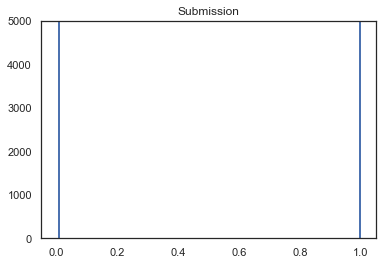

testdata = 421665
1.34% of testdata = 5650.0
fraud predict = 7579


In [14]:
# 结果保存
plt.hist(predictions,bins=100)
plt.ylim((0,5000))
plt.title('Submission')
plt.show()
#sampleSubmission = pd.read_csv('/content/submission_test_sample.csv')
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test_xgb64.csv',index = None)

print('testdata =',test_data['txkey'].count())
print('1.34% of testdata =',round(test_data['txkey'].count()*0.0134))
print('fraud predict =',sampleSubmission['fraud_ind'].value_counts()[1])

In [1]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma,learning_rate,min_child_weight,subsample,colsample_bytree,reg_alpha,reg_lambda):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': 1000,
              'scale_pos_weight':73.76231884057971,
              'learning_rate':learning_rate,
              'min_child_weight':int(min_child_weight), 
              'colsample_bytree':colsample_bytree,
              'subsample':subsample,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda,
              'eta': 0.1,
              'missing' : -1,
              'objective' :'binary:logistic',
              'tree_method':'gpu_hist',
              'eval_metric': 'auc'}
    dtrain = xgb.DMatrix(X_train, Y_train, missing=-1)   
    cv_result = xgb.cv(params, dtrain, num_boost_round=5000, early_stopping_rounds=200, nfold=3)    
    return cv_result['test-auc-mean'].iloc[-1]

In [ ]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (20, 200),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             #'n_estimators':(90,101),
                                             'min_child_weight':(1,6),
                                            'subsample':(0.6,0.9),
                                            'colsample_bytree':(0.6,0.9),
                                            'reg_alpha':(0.05,3),
                                            'reg_lambda':(0.05,3),                                            
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------


C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\kiwi\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

In [ ]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
classifier2 = XGBClassifier(**params).fit(text_tfidf, clean_data_train['author'])

#predicting for training set
train_p2 = classifier2.predict(text_tfidf)

#Looking at the classification report
print(classification_report(train_p2, clean_data_train['author']))